# Getting the Neighborhood Model
## User and Item Based models using KNN for predictions
The following notebook holds the code for how we selected, tuned, and evaluated the user and item based models for predicting a user's book ratings.

## Importing packages and reading data

In [297]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',100)
from __future__ import (absolute_import, division, print_function, unicode_literals)
from sklearn.model_selection import train_test_split
import surprise
import random
random.seed(42)
import time
from collections import defaultdict
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def read_data(path):
    df = pd.read_csv(path)
    return df

In [3]:
ratings = read_data('ratings.csv')

In [4]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


### Sampling From Data for Tuning and Scalability
All of the subsets of this data will be used to show the scalability of our model. We will be using the 10k users and 100 items subset for gridsearch and tuning

In [224]:
#Function to pick a new dataset with the num_users most prolific reviewers and num_books most reviewed books
def pick_users_books(df, num_users, num_books):
    #Taking a list of the num_users most prolific users
    user_counts = pd.DataFrame(df.user_id.value_counts()).sort_values('user_id', ascending=False)
    top_10K_users = list(user_counts[0:num_users].index)
    #Taking the rows from the dataframe with the most prolific users
    user_filtered_df = df[df.user_id.isin(top_10K_users)]
    
    #Repeating above for books
    filtered_book_counts = pd.DataFrame(user_filtered_df.book_id.value_counts()).sort_values('book_id', ascending = False)
    top_100_filtered_books = list(filtered_book_counts[0:num_books].index)
    filtered_df = user_filtered_df[user_filtered_df.book_id.isin(top_100_filtered_books)]
    
    print("New dataframe has {} users, {} items, and a sparsity of {}".format(len(filtered_df.user_id.unique()),len(filtered_df.book_id.unique()),len(filtered_df)/(len(filtered_df.user_id.unique())*len(filtered_df.book_id.unique()))))
    #Taking a separate Test set for unbiased estimation
    train, test = train_test_split(filtered_df, test_size = 0.2, random_state=42)
    return train, test

#Takes 6 subsets of the data using the above function
def get_all_subsets(df):
    train_500_20, test_500_20 = pick_users_books(df, 500, 20)
    train_1000_35, test_1000_35 = pick_users_books(df, 1000, 35)
    train_2000_50, test_2000_50 = pick_users_books(df, 2000, 50)
    train_5000_70, test_5000_70 = pick_users_books(df, 5000, 70)
    train_7500_85, test_7500_85 = pick_users_books(df, 7500, 85)
    train_10000_100, test_10000_100 = pick_users_books(df, 10000, 100)
    return train_500_20, test_500_20, train_1000_35, test_1000_35, train_2000_50, test_2000_50, \
        train_5000_70, test_5000_70, train_7500_85, test_7500_85, train_10000_100, test_10000_100

In [225]:
train_500_20, test_500_20, train_1000_35, test_1000_35, train_2000_50, test_2000_50, \
        train_5000_70, test_5000_70, train_7500_85, test_7500_85, train_10000_100, test_10000_100 = get_all_subsets(ratings)

New dataframe has 487 users, 20 items, and a sparsity of 0.442607802875
New dataframe has 985 users, 35 items, and a sparsity of 0.404118926759
New dataframe has 1981 users, 50 items, and a sparsity of 0.374558303887
New dataframe has 4980 users, 70 items, and a sparsity of 0.324036144578
New dataframe has 7479 users, 85 items, and a sparsity of 0.295368207451
New dataframe has 9980 users, 100 items, and a sparsity of 0.271965931864


In [167]:
#Function to perform the gridsearch using surprise given sets of parameters to test
def grid_search_data(df, algorithm, parameter_grid, metrics):
    reader = surprise.Reader(rating_scale=(1,5))
    data = surprise.Dataset.load_from_df(df, reader)
    data.split(n_folds = 3)
    grid_search = surprise.GridSearch(algorithm, parameter_grid, measures = metrics)
    grid_search.evaluate(data)
    results_df = pd.DataFrame.from_dict(grid_search.cv_results)
    return results_df

In [194]:
#Function converting the above function to a more readable DataFrame
def convert_grid_results(df):
    #Initializing
    my_dict = df.to_dict('list')
    min_support = []
    name = []
    user_based = []
    k = []
    #Saving all of the necessary parameters in their own columns before deleting the keys from my_dict
    for x in my_dict['params']:
        k.append(x['k'])
    for x in range(len(my_dict['sim_options'])):
        y = my_dict['sim_options'][x]
        min_support.append(y['min_support'])
        name.append(y['name'])
        user_based.append(y['user_based'])
    del my_dict['params']
    del my_dict['scores']
    del my_dict['sim_options']
    #Putting the parameters back into my_dict
    my_dict['k'] = k
    my_dict['min_support'] = min_support
    my_dict['name'] = name
    my_dict['user_based'] = user_based
    my_df = pd.DataFrame.from_dict(my_dict)
    return my_df

### Grid searching KNN scaled by the mean with users on 10k users, 100 items sample

We started by testing KNN user-based approaches. We did a grid search to tune our hyperparameters (K, similarity metric, and minimum support) for the model. We also tested two algorithms, one which scaled the ratings by the means, and one which scaled them by the Z-score. The full grid can be seen in the dataframe below.

KNN scaled by the means:

$$
\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}
$$

In [169]:
algorithm1 = surprise.prediction_algorithms.knns.KNNWithMeans
param_grid = {'k': [10, 50, 200], 'sim_options': {'name': ['msd', 'pearson', 'pearson_baseline'], 'min_support': [1, 3], 'user_based': [True]}}
KNN_means_results_full = grid_search_data(train_10000_100, algorithm1, param_grid, ['RMSE'])

[{u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': True}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': True}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': True}, u'k': 50}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': True}, u'k': 200}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': True}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': True}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': True}, u'k': 50}, {u'sim_options': {u

In [195]:
KNN_means_results_full_df_user = convert_grid_results(KNN_means_results_full)
KNN_means_results_full_df_user

,RMSE,k,min_support,name,user_based
0,0.927773,10,1,msd,True
1,0.898820,50,1,msd,True
2,0.889167,200,1,msd,True
3,0.910945,10,3,msd,True
4,0.883578,50,3,msd,True
5,0.881968,200,3,msd,True
6,0.926526,10,1,pearson,True
7,0.896781,50,1,pearson,True
8,0.886311,200,1,pearson,True
9,0.918250,10,3,pearson,True


### Grid searching KNN scaled by z score with users on 10k users, 100 items sample

Now we are using KNN scaled by the Z score. We tuned the same hyperparameters as before. This is how the predictions are made using KNN scaled by the Z score. This formula and the last one are both for the user-based approach:

$$
\hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v
\in N^k_i(u)} \text{sim}(u, v)}
$$

In [182]:
algorithm1 = surprise.prediction_algorithms.knns.KNNWithZScore
param_grid = {'k': [10, 50, 200], 'sim_options': {'name': ['msd', 'pearson', 'pearson_baseline'], 'min_support': [1, 3], 'user_based': [True]}}
KNN_z_score_results_full_users = grid_search_data(train_10000_100, algorithm1, param_grid, ['RMSE'])

[{u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': True}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': True}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': True}, u'k': 50}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': True}, u'k': 200}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': True}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': True}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': True}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': True}, u'k': 50}, {u'sim_options': {u

In [199]:
KNN_z_score_results_full_df_users = convert_grid_results(KNN_z_score_results_full_users)
KNN_z_score_results_full_df_users

,RMSE,k,min_support,name,user_based
0,0.931628,10,1,msd,True
1,0.899557,50,1,msd,True
2,0.889263,200,1,msd,True
3,0.915632,10,3,msd,True
4,0.884591,50,3,msd,True
5,0.882098,200,3,msd,True
6,0.925362,10,1,pearson,True
7,0.895721,50,1,pearson,True
8,0.885117,200,1,pearson,True
9,0.919661,10,3,pearson,True


### Combining results from above two sections

In [207]:
KNN_user_grid_results_df = pd.concat([KNN_means_results_full_df_user, KNN_z_score_results_full_df_users])
KNN_user_grid_results_df['type'] = ['With Means'] * 18 + ['With Z score'] * 18
#Saving the results to csv
KNN_user_grid_results_df.to_csv('KNN_user_grid_results_df.csv')
KNN_user_grid_results_df

,RMSE,k,min_support,name,user_based,type
0,0.927773,10,1,msd,True,With Means
1,0.898820,50,1,msd,True,With Means
2,0.889167,200,1,msd,True,With Means
3,0.910945,10,3,msd,True,With Means
4,0.883578,50,3,msd,True,With Means
5,0.881968,200,3,msd,True,With Means
6,0.926526,10,1,pearson,True,With Means
7,0.896781,50,1,pearson,True,With Means
8,0.886311,200,1,pearson,True,With Means
9,0.918250,10,3,pearson,True,With Means


In [367]:
plot_KNN_user_grid = KNN_user_grid_results_df.loc[[12,13,14]]
plot_KNN_user_grid

,RMSE,k,min_support,name,user_based,type
12,0.891678,10,1,pearson_baseline,True,With Means
12,0.890958,10,1,pearson_baseline,True,With Z score
13,0.867488,50,1,pearson_baseline,True,With Means
13,0.869114,50,1,pearson_baseline,True,With Z score
14,0.869896,200,1,pearson_baseline,True,With Means
14,0.871111,200,1,pearson_baseline,True,With Z score


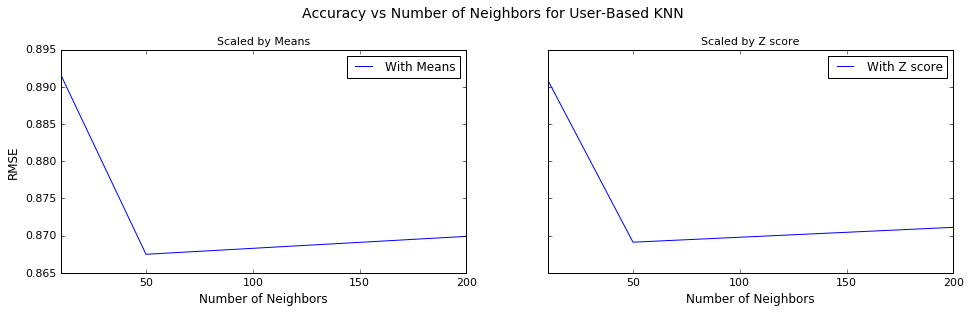

In [371]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4), sharey=True)

plot_KNN_user_grid[plot_KNN_user_grid['type']=='With Means'].plot(x='k',y='RMSE', label='With Means', ax=axes[0], fontsize='11', color='b')
axes[0].set_title('Scaled by Means', fontsize='11')
axes[0].set_xlabel('Number of Neighbors', fontsize='12')
axes[0].set_ylabel('RMSE', fontsize='12')

plot_KNN_user_grid[plot_KNN_user_grid['type']=='With Z score'].plot(x='k',y='RMSE', label='With Z score', ax=axes[1], fontsize='11', color='b')
axes[1].set_title('Scaled by Z score', fontsize='11')
axes[1].set_xlabel('Number of Neighbors', fontsize='12')
axes[1].set_ylabel('RMSE', fontsize='12')

fig.suptitle('Accuracy vs Number of Neighbors for User-Based KNN', y=1.05, fontsize='14')

In this case, there likely weren't enough values of K tested. However, given the 3 values tested, 50 is an obvious choice to use for the final algorithm. Both algorithms have 50 as the best number of neighbors.

In [217]:
#Finding the parameters for the best run
KNN_user_grid_results_df.iloc[KNN_user_grid_results_df['RMSE'].idxmin()]

RMSE                   0.867488
k                            50
min_support                   1
name           pearson_baseline
user_based                 True
type                 With Means
Name: 13, dtype: object

After combining the results from the two KNN algorithms in one dataframe, we can see that the best RMSE we achieved was 0.8675. This algorithm was KNN scaled by means with parameters: K = 50, min_support = 1, similarity_metric = pearson_baseline

### Grid searching KNN scaled by the mean with items on 10k users, 100 items sample

Here, we have repeated the above process as an item-based model

In [173]:
algorithm1 = surprise.prediction_algorithms.knns.KNNWithMeans
param_grid = {'k': [10, 50, 200], 'sim_options': {'name': ['msd', 'pearson', 'pearson_baseline'], 'min_support': [1, 3], 'user_based': [False]}}
KNN_means_results_full_items = grid_search_data(train_10000_100, algorithm1, param_grid, ['RMSE'])

[{u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': False}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': False}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': False}, u'k': 50}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': False}, u'k': 200}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': False}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': False}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': False}, u'k': 50}, {u'sim_o

In [196]:
KNN_means_results_full_df_items = convert_grid_results(KNN_means_results_full_items)
KNN_means_results_full_df_items

,RMSE,k,min_support,name,user_based
0,0.878344,10,1,msd,False
1,0.888194,50,1,msd,False
2,0.888193,200,1,msd,False
3,0.878344,10,3,msd,False
4,0.888194,50,3,msd,False
5,0.888193,200,3,msd,False
6,0.865087,10,1,pearson,False
7,0.868604,50,1,pearson,False
8,0.868604,200,1,pearson,False
9,0.865087,10,3,pearson,False


### Grid searching KNN scaled by z-score with items on 10k users, 100 items sample

In [200]:
algorithm1 = surprise.prediction_algorithms.knns.KNNWithZScore
param_grid = {'k': [10, 50, 200], 'sim_options': {'name': ['msd', 'pearson', 'pearson_baseline'], 'min_support': [1, 3], 'user_based': [False]}}
KNN_z_score_results_full_items = grid_search_data(train_10000_100, algorithm1, param_grid, ['RMSE'])

[{u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': False}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'msd', u'user_based': False}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': False}, u'k': 50}, {u'sim_options': {u'min_support': 3, u'name': u'msd', u'user_based': False}, u'k': 200}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': False}, u'k': 50}, {u'sim_options': {u'min_support': 1, u'name': u'pearson', u'user_based': False}, u'k': 200}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': False}, u'k': 10}, {u'sim_options': {u'min_support': 3, u'name': u'pearson', u'user_based': False}, u'k': 50}, {u'sim_o

In [202]:
KNN_z_score_results_full_df_items = convert_grid_results(KNN_z_score_results_full_items)
KNN_z_score_results_full_df_items

,RMSE,k,min_support,name,user_based
0,0.884392,10,1,msd,False
1,0.891244,50,1,msd,False
2,0.891244,200,1,msd,False
3,0.884392,10,3,msd,False
4,0.891244,50,3,msd,False
5,0.891244,200,3,msd,False
6,0.866746,10,1,pearson,False
7,0.870073,50,1,pearson,False
8,0.870073,200,1,pearson,False
9,0.866746,10,3,pearson,False


### Combining grid search results for item-based KNN model

In [208]:
KNN_items_grid_results_df = pd.concat([KNN_means_results_full_df_items, KNN_z_score_results_full_df_items])
KNN_items_grid_results_df['type'] = ['With Means'] * 18 + ['With Z score'] * 18
#Saving the results of grid search
KNN_items_grid_results_df.to_csv('KNN_items_grid_results_df.csv')
KNN_items_grid_results_df

,RMSE,k,min_support,name,user_based,type
0,0.878344,10,1,msd,False,With Means
1,0.888194,50,1,msd,False,With Means
2,0.888193,200,1,msd,False,With Means
3,0.878344,10,3,msd,False,With Means
4,0.888194,50,3,msd,False,With Means
5,0.888193,200,3,msd,False,With Means
6,0.865087,10,1,pearson,False,With Means
7,0.868604,50,1,pearson,False,With Means
8,0.868604,200,1,pearson,False,With Means
9,0.865087,10,3,pearson,False,With Means


In [373]:
plot_KNN_item_grid = KNN_items_grid_results_df.loc[[6,7,8]]
plot_KNN_item_grid

,RMSE,k,min_support,name,user_based,type
6,0.865087,10,1,pearson,False,With Means
6,0.866746,10,1,pearson,False,With Z score
7,0.868604,50,1,pearson,False,With Means
7,0.870073,50,1,pearson,False,With Z score
8,0.868604,200,1,pearson,False,With Means
8,0.870073,200,1,pearson,False,With Z score


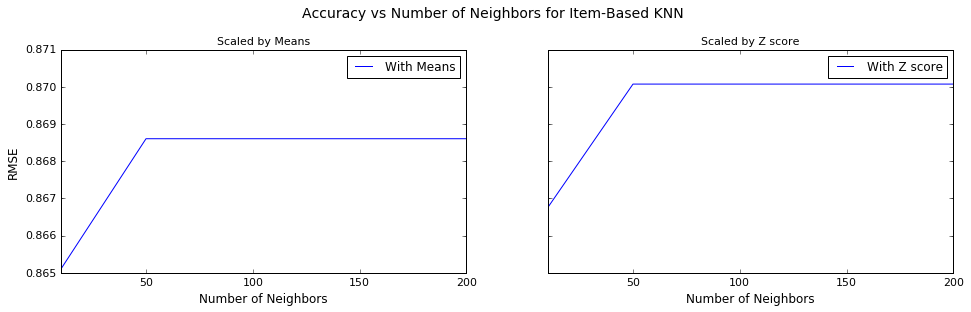

In [374]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4), sharey=True)

plot_KNN_item_grid[plot_KNN_item_grid['type']=='With Means'].plot(x='k',y='RMSE', label='With Means', ax=axes[0], fontsize='11', color='b')
axes[0].set_title('Scaled by Means', fontsize='11')
axes[0].set_xlabel('Number of Neighbors', fontsize='12')
axes[0].set_ylabel('RMSE', fontsize='12')

plot_KNN_item_grid[plot_KNN_item_grid['type']=='With Z score'].plot(x='k',y='RMSE', label='With Z score', ax=axes[1], fontsize='11', color='b')
axes[1].set_title('Scaled by Z score', fontsize='11')
axes[1].set_xlabel('Number of Neighbors', fontsize='12')
axes[1].set_ylabel('RMSE', fontsize='12')

fig.suptitle('Accuracy vs Number of Neighbors for Item-Based KNN', y=1.05, fontsize='14')

In the item-based model, we only have 100 items. This is likely to few items to be using K = 50, and obviously to be testing K = 200. It also is seen that there is no difference from 50 to 200. Given the graph, it is likely that the optimal number of K actually appears below 10. We should go back and test this.

In [230]:
#Finding the best parameters
KNN_items_grid_results_df.iloc[KNN_items_grid_results_df['RMSE'].idxmin()]

RMSE             0.865087
k                      10
min_support             1
name              pearson
user_based          False
type           With Means
Name: 6, dtype: object

Our best item-based model achieved a mean cross-validation RMSE of 0.8651. Again, we used KNN scaled by the means. The hyperparameters were: k=10, min_support=1, similarity_metric=perason

### Testing Scalability of Neighbourhood Models

In [226]:
#Combine train and test sets for use with surprise package
all_10000_100 = train_10000_100.append(test_10000_100)
all_500_20 = train_500_20.append(test_500_20)
all_1000_35 = train_1000_35.append(test_1000_35)
all_2000_50 = train_2000_50.append(test_2000_50)
all_5000_70 = train_5000_70.append(test_5000_70)
all_7500_85 = train_7500_85.append(test_7500_85)

#Function to time and test algorithms on our 6 subsets of the data to test scalability with time and accuracy
def train_test(dataframe, num_users, num_books, algorithm):
    print("\nEvaluating for {} users and {} books".format(num_users, num_books))
    
    #Capture start time
    start_train_time = time.time()
    
    #set up reader and get data from dataframe
    reader = surprise.Reader(rating_scale=(1, 5))
    data = surprise.Dataset.load_from_df(dataframe[['user_id', 'book_id', 'rating']], reader)
    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()
    antitestset = trainset.build_anti_testset()
    #Set up algorithm
    algo = algorithm
    #Train algorithm
    algo.train(trainset)
    #print train time
    end_train_time = time.time()
    print("training: --- %s seconds ---" % (end_train_time - start_train_time))
    #Get predictions
    predictions = algo.test(testset)
    #Print prediction time
    print("predicting: --- %s seconds ---" % (time.time() - end_train_time))
    #Evaluate accuracy measures
    surprise.accuracy.rmse(predictions, verbose=True)
    surprise.accuracy.mae(predictions, verbose=True)
    surprise.accuracy.fcp(predictions, verbose=True)
    
    return predictions


### Item Based Scalability

In [231]:
algorithm = surprise.prediction_algorithms.knns.KNNWithMeans(k=10, min_k=1, sim_options={'name' : 'pearson',
                                                                                        'user_based' : False,
                                                                                        'min_support' : 1})
predictions_500_20 = train_test(all_500_20,500,20, algorithm)
predictions_1000_35 = train_test(all_1000_35,1000,35, algorithm)
predictions_2000_50 = train_test(all_2000_50,2000,50, algorithm)
predictions_5000_70 = train_test(all_5000_70,5000,70, algorithm)
predictions_7500_85 = train_test(all_7500_85,7500,85, algorithm)
predictions_10000_100 = train_test(all_10000_100,10000,100, algorithm)


Evaluating for 500 users and 20 books
Computing the pearson similarity matrix...
Done computing similarity matrix.
training: --- 0.0994210243225 seconds ---
predicting: --- 0.178478956223 seconds ---
RMSE: 0.5605
MAE:  0.4222
FCP:  0.8617

Evaluating for 1000 users and 35 books
Computing the pearson similarity matrix...
Done computing similarity matrix.
training: --- 0.350890159607 seconds ---
predicting: --- 0.75106883049 seconds ---
RMSE: 0.5763
MAE:  0.4301
FCP:  0.8765

Evaluating for 2000 users and 50 books
Computing the pearson similarity matrix...
Done computing similarity matrix.
training: --- 0.93994808197 seconds ---
predicting: --- 2.17092108727 seconds ---
RMSE: 0.5816
MAE:  0.4376
FCP:  0.8892

Evaluating for 5000 users and 70 books
Computing the pearson similarity matrix...
Done computing similarity matrix.
training: --- 4.01583814621 seconds ---
predicting: --- 9.92995691299 seconds ---
RMSE: 0.5874
MAE:  0.4434
FCP:  0.8905

Evaluating for 7500 users and 85 books
Compu

### User Based Scalability

In [228]:
algorithm = surprise.prediction_algorithms.knns.KNNWithMeans(k=50, min_k=1, sim_options={'name' : 'pearson_baseline',
                                                                                        'user_based' : True,
                                                                                        'min_support' : 1})
predictions_500_20 = train_test(all_500_20,500,20, algorithm)
predictions_1000_35 = train_test(all_1000_35,1000,35, algorithm)
predictions_2000_50 = train_test(all_2000_50,2000,50, algorithm)
predictions_5000_70 = train_test(all_5000_70,5000,70, algorithm)
predictions_7500_85 = train_test(all_7500_85,7500,85, algorithm)
predictions_10000_100 = train_test(all_10000_100,10000,100, algorithm)


Evaluating for 1000 users and 35 books
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
training: --- 1.27686214447 seconds ---
predicting: --- 11.8497738838 seconds ---
RMSE: 0.3341
MAE:  0.2352
FCP:  0.9743

Evaluating for 5000 users and 70 books
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
training: --- 38.4362478256 seconds ---
predicting: --- 293.470230103 seconds ---
RMSE: 0.3546
MAE:  0.2564
FCP:  0.9772

Evaluating for 7500 users and 85 books
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
training: --- 86.9135189056 seconds ---
predicting: --- 636.902920008 seconds ---
RMSE: 0.3676
MAE:  0.2673
FCP:  0.9741


### Testing Coverage

In this section, we test and plot the scalability of both the user and item based models to make a final selection

In [254]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def calc_item_coverage(top_n, num_books):
    bookset = set()
    for book in top_n.keys():
        for pair in top_n[book]:
            bookset.add(pair[0])
    return float(len(bookset))/num_books

In [256]:
# Function to calculate spearman coefficient from surPRISE predictions
from scipy.stats import spearmanr
def spearman(predictions):
    dict_ratings = {}
    spearmans = []
    for uid, iid, true_r, est, _ in predictions:
        if float(true_r) and float(est) and not np.isnan(true_r) and not np.isnan(est):
            if uid in dict_ratings.keys():
                dict_ratings[uid][0].append(true_r)
                dict_ratings[uid][1].append(est)
            else:
                dict_ratings[uid]=[[true_r],[est]]
    for uid in dict_ratings.keys():
        if len(dict_ratings[uid][0])>1:
            spearman = spearmanr(dict_ratings[uid][0], dict_ratings[uid][1])[0]
            if np.isnan(spearman) == False: # spearman is NaN if all true ratings are the same! exclude these
                spearmans.append(spearman)
    return np.mean(spearmans)

In [342]:
def test_coverage(dataframe, algorithm):
    n_ratings = len(dataframe)
    num_users = len(dataframe.user_id.unique())
    num_books = len(dataframe.book_id.unique())
    print("\nEvaluating for {} users and {} books; number of ratings: {}".format(num_users, num_books, n_ratings))
    
    #set up reader and get data from dataframe
    reader = surprise.Reader(rating_scale=(1, 5))
    data = surprise.Dataset.load_from_df(dataframe[['user_id', 'book_id', 'rating']], reader)

    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()
    antitestset = trainset.build_anti_testset()

    #Set up algorithm
    algo = algorithm
    
    #Capture start time
    start_time = time.time()

    #Train algorithm
    algo.train(trainset)
    
    train_time = time.time() - start_time
    
    #Print training algorithm time
    print("---Training: %s seconds ---" % (train_time))

    #Capture start time - test
    start_time = time.time()
    
    #Get predictions
    predictions = algo.test(testset)
    
    test_time = time.time() - start_time
    
    #Print training algorithm time
    print("---Testing: %s seconds ---" % (test_time))

    #Evaluate accuracy measures
    rmse = surprise.accuracy.rmse(predictions, verbose=True)
    mae = surprise.accuracy.mae(predictions, verbose=True)
#    surprise.accuracy.fcp(predictions, verbose=True)
    spman = spearman(predictions)
    print("SPEARMAN:  {}".format(spman))
    
    true_predictions = algo.test(antitestset)
    top_n = get_top_n(true_predictions, n=10)
    
    print("COVERAGE: {}".format(calc_item_coverage(top_n, num_books)))
    
    
    return [train_time, test_time, n_ratings, rmse, mae, spman, num_users, num_books]

In [343]:
# Item based
algorithm_items = surprise.prediction_algorithms.knns.KNNWithMeans(k=10, min_k=1, sim_options={'name' : 'pearson',
                                                                                        'user_based' : False,
                                                                                        'min_support' : 1})


In [344]:
running_tuples=[(all_500_20,500,20),(all_1000_35,1000,35),(all_2000_50,2000,50),(all_5000_70,5000,70),(all_7500_85,7500,85),(all_10000_100,10000,100)]

#Run SGD baseline on all subsets
results_items = []
for i in running_tuples:
    results_vector = test_coverage(i[0], algorithm_items)
    results_items.append(results_vector)


Evaluating for 487 users and 20 books; number of ratings: 4311
Computing the pearson similarity matrix...
Done computing similarity matrix.
---Training: 0.00729393959045 seconds ---
---Testing: 0.214583873749 seconds ---
RMSE: 0.5605
MAE:  0.4222
SPEARMAN:  0.781364391063
COVERAGE: 1.0

Evaluating for 985 users and 35 books; number of ratings: 13932
Computing the pearson similarity matrix...
Done computing similarity matrix.
---Training: 0.0283570289612 seconds ---
---Testing: 0.86647605896 seconds ---
RMSE: 0.5763
MAE:  0.4301
SPEARMAN:  0.756998337632
COVERAGE: 1.0

Evaluating for 1981 users and 50 books; number of ratings: 37100
Computing the pearson similarity matrix...
Done computing similarity matrix.
---Training: 0.0671579837799 seconds ---
---Testing: 2.06699514389 seconds ---
RMSE: 0.5816
MAE:  0.4376
SPEARMAN:  0.763650626618
COVERAGE: 1.0

Evaluating for 4980 users and 70 books; number of ratings: 112959
Computing the pearson similarity matrix...
Done computing similarity m

In [345]:
results_df_items = pd.DataFrame(results_items)
results_df_items.columns = ['train_time', 'test_time', 'n_ratings', 'rmse', 'mae', 'spearman', 'n_users', 'n_books']
results_df_items

,train_time,test_time,n_ratings,rmse,mae,spearman,n_users,n_books
0,0.007294,0.214584,4311,0.560502,0.422187,0.781364,487,20
1,0.028357,0.866476,13932,0.576334,0.430077,0.756998,985,35
2,0.067158,2.066995,37100,0.581553,0.437645,0.763651,1981,50
3,0.214168,7.095435,112959,0.587389,0.443351,0.760163,4980,70
4,0.417839,12.324254,187770,0.589832,0.447045,0.763991,7479,85
5,0.664450,18.438434,271422,0.587589,0.445030,0.765656,9980,100


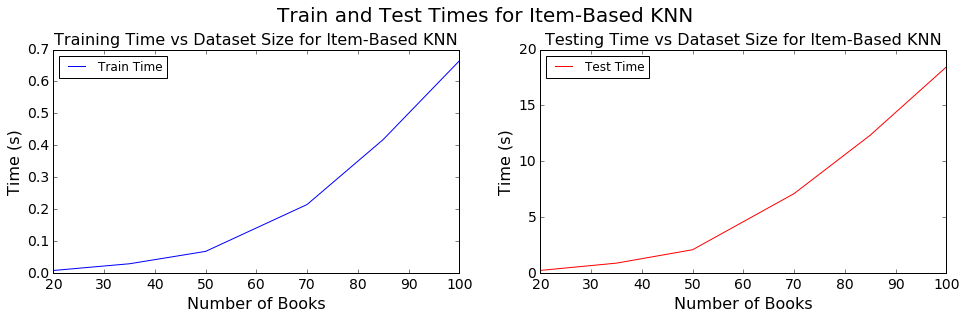

In [351]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4), sharey=False)

results_df_items.plot(x='n_books',y='train_time', label='Train Time', ax=axes[0], fontsize='14', color='b')
axes[0].set_title('Training Time vs Dataset Size for Item-Based KNN', fontsize='16')
axes[0].set_xlabel('Number of Books', fontsize='16')
axes[0].set_ylabel('Time (s)', fontsize='16')

results_df_items.plot(x='n_books',y='test_time', label='Test Time', ax=axes[1], fontsize='14', color='r')
axes[1].set_title('Testing Time vs Dataset Size for Item-Based KNN', fontsize='16')
axes[1].set_xlabel('Number of Books', fontsize='16')
axes[1].set_ylabel('Time (s)', fontsize='16')
fig.suptitle('Train and Test Times for Item-Based KNN', y=1.05, fontsize='20')

The above graphs clearly show that the training time and the prediction (test) time both scale exponentially with regards to the total number of books in the dataset. This makes sense as the algorithm has to compare each item to each other item for both similarity metrics to train and for predicting with KNN. Thus, as the number of items will be very large, it will no longer be feasible to use this approach

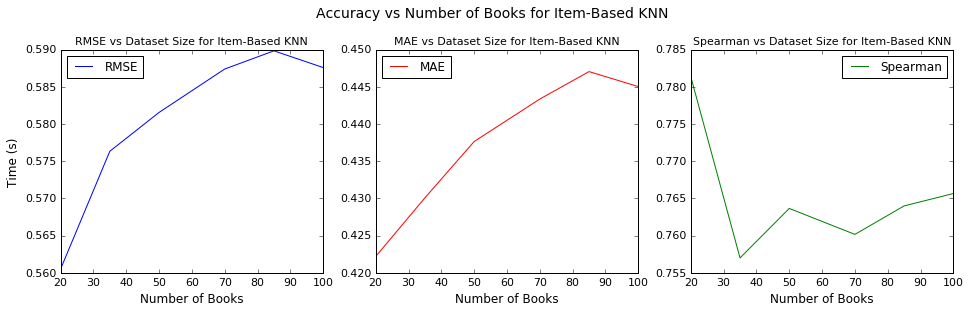

In [360]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=False)

results_df_items.plot(x='n_books',y='rmse', label='RMSE', ax=axes[0], fontsize='11', color='b')
axes[0].set_title('RMSE vs Dataset Size for Item-Based KNN', fontsize='11')
axes[0].set_xlabel('Number of Books', fontsize='12')
axes[0].set_ylabel('Time (s)', fontsize='12')

results_df_items.plot(x='n_books',y='mae', label='MAE', ax=axes[1], fontsize='11', color='r')
axes[1].set_title('MAE vs Dataset Size for Item-Based KNN', fontsize='11')
axes[1].set_xlabel('Number of Books', fontsize='12')

results_df_items.plot(x='n_books',y='spearman', label='Spearman', ax=axes[2], fontsize='11', color='g')
axes[2].set_title('Spearman vs Dataset Size for Item-Based KNN', fontsize='11')
axes[2].set_xlabel('Number of Books', fontsize='12')

fig.suptitle('Accuracy vs Number of Books for Item-Based KNN', y=1.05, fontsize='14')

The above graphs show that the accuracy tends to decrease with an increase in the number of books used. This makes sense as the data should become more sparse meaning we have to predict a larger percentage of the ratings. It is somewhat strange to see that RMSE and MAE actually start to drop again going from 85 to 100 books. Since we are hoping for a spearman coefficient closer to 1, it makes sense that as the data becomes larger and more sparse, it begins to drop. There seems to be a lot of variance in these accuracy metrics given the small number of books

In [375]:
#User based
algorithm_users = surprise.prediction_algorithms.knns.KNNWithMeans(k=50, min_k=1, sim_options={'name' : 'pearson_baseline',
                                                                                        'user_based' : True,
                                                                                        'min_support' : 1})


In [270]:
running_tuples=[(all_500_20,500,20),(all_1000_35,1000,35),(all_2000_50,2000,50),(all_5000_70,5000,70),(all_7500_85,7500,85),(all_10000_100,10000,100)]

#Run SGD baseline on all subsets
results_users = []
for i in running_tuples:
    results_vector = test_coverage(i[0], algorithm_users)
    results_users.append(results_vector)

## MOST LIKELY IGNORING EVERYTHING BELOW